# **밀도기반 군집화 (Density-based clustering)**
### **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
- **데이터 포인트의 밀도를 기준으로 클러스터를 형성하며, 밀도가 낮은 영역에 위치한 데이터 포인트는 noise로 간주**
- **복잡한 형태의 클러스터와 noise가 많은 데이터셋에서 효과적이며 이상탐지에 활용**

# **2.실습**

## **2-1.필요한 라이브러리 임포트**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 정규화 패키지
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 군집분석 관련 패키지
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 차원축소를 위한 패키지
from sklearn.decomposition import PCA

## **2-2. 데이터셋 설명 (Credit Card Fraud Detection)**
- **Time: 첫 거래와의 경과 시간 (초 단위)**
- **Amount: 거래 금액**
- **X 변수: 거래 특성으로 민감 정보 보호를 위해 암호화**
- **Y 변수: 거래유형 (2개 클래스 :  0 = 정상 거래, 1 = 사기 거래)**

## **2-3.데이터 로드 및 전처리**

In [ ]:
# 신용카드 데이터셋 로드
credit_df = pd.read_csv("../Data/creditcard.csv")
credit_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
# 결측치 확인
credit_df.isnull().sum().sum()

0

In [ ]:
# 데이터 내 사기거래 수 확인 (사기거래의 수가 매우 적음)
mask_anomal = credit_df['Class'] == 1
credit_df.loc[mask_anomal]

#### **계산비용이 높은 DBSCAN에 해당 데이터 셋을 적용하기 위해, 전체 데이터 셋의 일부만을 사용**

In [28]:
# 클래스 비율 확인
print("클래스 비율 확인:")
print(credit_df["Class"].value_counts())

# 클래스 비율 계산
total_samples = len(credit_df)
fraud_samples = len(credit_df[credit_df["Class"] == 1])
normal_samples = len(credit_df[credit_df["Class"] == 0])

print(f"전체 데이터 수: {total_samples}")
print(f"사기 거래 수 (Class 1): {fraud_samples}")
print(f"정상 거래 수 (Class 0): {normal_samples}")

클래스 비율 확인:
0    284315
1       492
Name: Class, dtype: int64
전체 데이터 수: 284807
사기 거래 수 (Class 1): 492
정상 거래 수 (Class 0): 284315


In [32]:
# 클래스 비율을 유지하면서 10% 샘플링
credit_df_balanced, _ = train_test_split(credit_df, 
                                        test_size=0.9,  # 90% 제거, 10% 유지
                                        stratify=credit_df["Class"],  # 클래스 비율 유지
                                        random_state=42)

In [33]:
# 샘플링 결과 확인
print("샘플링된 데이터셋 클래스 비율:")
print(credit_df_balanced["Class"].value_counts())

샘플링된 데이터셋 클래스 비율:
0    28431
1       49
Name: Class, dtype: int64


In [36]:
credit_df_balanced

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
177282,123113.0,-4.168525,-4.164323,1.911850,1.130443,4.152041,-2.125948,-1.803619,0.675859,0.308972,...,-0.058678,-1.673241,0.937707,-0.616568,0.780497,-1.055841,-0.154194,0.146745,157.37,0
99433,67116.0,-0.241374,-0.043836,1.545847,-0.950404,-0.819948,0.847419,-0.786322,-1.420254,1.645278,...,1.222000,-1.007936,-0.415337,-0.336823,1.033332,0.848539,0.117121,0.092623,96.35,0
182653,125495.0,-2.134432,-2.219310,0.969065,-2.858480,0.693123,-1.315593,0.284006,0.149392,1.182680,...,0.579502,0.743960,0.519019,-0.354719,0.373946,-0.319379,-0.056289,0.155978,276.73,0
101035,67705.0,-0.862259,-0.224703,2.308340,-1.941343,-0.321210,1.954794,-0.942382,0.729052,0.090916,...,0.121589,0.683341,-0.590164,-1.645139,0.665159,-0.005705,0.219394,0.098477,2.00,0
94212,64782.0,1.241610,-0.051895,0.579918,-0.115431,-0.579488,-0.548451,-0.269573,-0.041116,0.353210,...,-0.103847,-0.237586,0.124342,0.143650,0.053582,0.933286,-0.052477,0.006476,1.54,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271650,164675.0,-0.179026,0.943564,0.159355,0.713100,1.087442,0.390270,0.802591,0.088052,-0.341001,...,0.212203,0.978882,-0.493097,-1.063402,0.173113,-0.200831,0.453460,0.223779,8.00,0
113266,72999.0,-3.826287,-2.288348,0.843972,-0.288038,2.748319,-0.529788,0.505155,-0.843771,0.950461,...,-0.992128,-0.485620,0.487403,-1.108481,0.308781,-0.033623,-0.958645,0.286987,11.83,0
188681,128081.0,2.071255,-0.433516,-3.071114,-1.575368,0.736294,-1.725837,1.051549,-0.685897,0.997689,...,0.317018,0.971460,-0.317930,0.587448,0.871183,0.199648,-0.103865,-0.073293,90.25,0
199115,132815.0,2.123341,-0.257764,-1.466731,-0.714225,0.026685,-1.049025,0.096077,-0.281468,0.837886,...,-0.306540,-0.838143,0.384608,0.675921,-0.370399,0.512908,-0.109321,-0.061377,4.00,0


In [37]:
# 데이터 스케일링
X = credit_df_balanced.iloc[:, 1:-2]
y = credit_df_balanced.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **2-4.주성분 분석(PCA)**

In [38]:
# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## **2-5.DBSCAN**

In [ ]:
# DBSCAN 모델 생성
dbscan = DBSCAN(eps=0.5, min_samples=10)

# eps = 이웃으로 간주할 수 있는 데이터 포인트 간의 거리의 최대값, // eps가 높으면 작으면 밀도가 높은 데이터도 분할되어 일부 포인트가 노이즈로 간주
# min_samples = 군집으로 간주되기 위해 eps 반경 내에 존재해야 하는 최소 데이터 포인트 수

# 모델 학습 및 군집화 수행
clusters = dbscan.fit_predict(X_pca)  # PCA로 축소된 데이터 사용

# 클러스터 레이블 출력
# 군집에 속하지 못한 데이터 : -1
# 소수 군집(1, 2, 3)은 패턴이 살짝 다른 데이터를 포함하고 있을 수 있음
print("\nDBSCAN 클러스터 레이블 확인:")
print(np.unique(clusters))


DBSCAN 클러스터 레이블 확인:
[-1  0  1  2  3]


In [ ]:
# 클러스터 레이블별 데이터 개수 확인
unique, counts = np.unique(clusters, return_counts=True)
for label, count in zip(unique, counts):
    print(f"클러스터 {label}: {count}개 데이터")

클러스터 -1: 245개 데이터
클러스터 0: 28121개 데이터
클러스터 1: 90개 데이터
클러스터 2: 15개 데이터
클러스터 3: 9개 데이터


## **2-6.시각화**

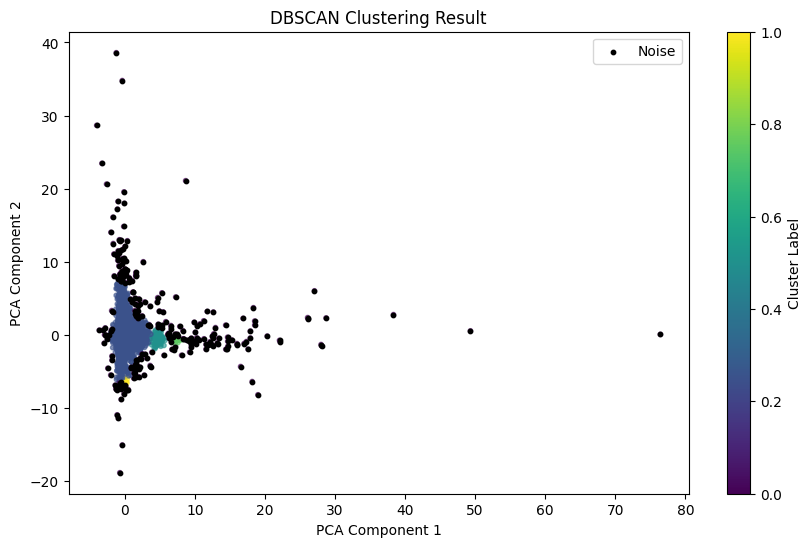

In [41]:
# DBSCAN 결과 시각화
plt.figure(figsize=(10, 6))

# 각 클러스터에 색상 할당 (-1은 노이즈로 검정색 표시)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis", s=10, alpha=0.6)

# 노이즈 데이터 강조 (클러스터 -1)
plt.scatter(X_pca[clusters == -1, 0], X_pca[clusters == -1, 1], 
            color="black", s=10, label="Noise")

# 그래프 설정
plt.title("DBSCAN Clustering Result")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.colorbar(label="Cluster Label")
plt.show()

## **2-7.결과 평가**

In [44]:
# 노이즈(-1)를 제외한 데이터로 실루엣 점수 계산
if len(set(clusters)) > 1:  # 클러스터가 2개 이상 있어야 계산 가능
    silhouette = silhouette_score(X_pca, clusters)
    print(f"Silhouette Score: {silhouette:.3f}")
else:
    print("Silhouette Score를 계산할 수 없습니다. (클러스터가 하나만 존재)")

Silhouette Score: 0.784


## **2-8.하이퍼파라미터 튜닝**

In [46]:
# 튜닝할 파라미터 범위 설정
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 15]

best_eps = None
best_min_samples = None
best_score = -1

# Grid Search 실행
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_pca)
        
        # 군집 수가 1개 초과일 때만 실루엣 점수 계산
        if len(set(clusters)) > 1:
            score = silhouette_score(X_pca, clusters)
            print(f"eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score:.4f}")
            
            if score > best_score:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score

print("\n최적 파라미터:")
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score:.4f}")

eps: 0.3, min_samples: 5, Silhouette Score: 0.5356
eps: 0.3, min_samples: 10, Silhouette Score: 0.7884
eps: 0.3, min_samples: 15, Silhouette Score: 0.7681
eps: 0.5, min_samples: 5, Silhouette Score: 0.7877
eps: 0.5, min_samples: 10, Silhouette Score: 0.7836
eps: 0.5, min_samples: 15, Silhouette Score: 0.7884
eps: 0.7, min_samples: 5, Silhouette Score: 0.8572
eps: 0.7, min_samples: 10, Silhouette Score: 0.8503
eps: 0.7, min_samples: 15, Silhouette Score: 0.8454
eps: 1.0, min_samples: 5, Silhouette Score: 0.9099
eps: 1.0, min_samples: 10, Silhouette Score: 0.9290
eps: 1.0, min_samples: 15, Silhouette Score: 0.9230

최적 파라미터:
Best eps: 1.0, Best min_samples: 10, Best Silhouette Score: 0.9290
